In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift

# Set grid size and initialize parameters
N = 256  # Grid size
L = 128  # Physical length of the system
dx = L / N
x = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, x)

# Initialize random composition field with small perturbations
c = 0.1 * (np.random.rand(N, N) - 0.5)

# Define constants and time-stepping parameters
Bel = 2.0  # Elastic constant
dt = 0.01  # Time step
n_steps = 1000  # Number of time steps
k_vals = np.fft.fftfreq(N, d=dx) * 2 * np.pi
kx, ky = np.meshgrid(k_vals, k_vals)
k2 = kx**2 + ky**2  # k^2 in Fourier space
k4 = k2**2  # k^4 for biharmonic term

# Nonlinear term f(c)
def f(c):
    return c * (1 - c) * (1 + c)

# Elastic interaction term B(k)
def B(kx, ky, Bel=2.0):
    ex = kx / np.sqrt(kx**2 + ky**2 + 1e-12)
    ey = ky / np.sqrt(kx**2 + ky**2 + 1e-12)
    return Bel * (ex**2 - ey**2)

# Main simulation loop
for step in range(n_steps):
    # Compute Fourier transform of c
    c_hat = fft2(c)
    
    # Compute the nonlinear term in real space, then transform to Fourier space
    f_c_hat = fft2(f(c))
    
    # Update the composition field in Fourier space using the semi-implicit scheme
    B_hat = B(kx, ky, Bel)
    c_hat_new = (c_hat - dt * k2 * (f_c_hat + B_hat * c_hat)) / (1 + dt * k4)
    
    # Inverse FFT to get the updated composition field in real space
    c = np.real(ifft2(c_hat_new))
    
    # Visualize the composition field at regular intervals
    if step % 100 == 0:
        plt.figure(figsize=(6, 6))
        plt.imshow(c, extent=(-L/2, L/2, -L/2, L/2), cmap='bwr')
        plt.colorbar(label='Composition')
        plt.title(f'Step {step}')
        plt.show()


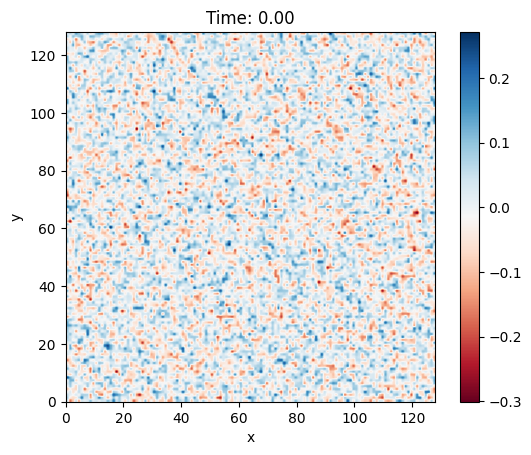

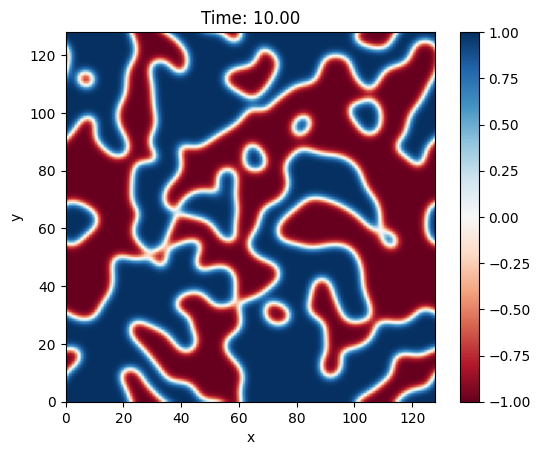

<Figure size 640x480 with 0 Axes>

In [1]:
import numpy as np
from scipy.fft import fft2, ifft2, fftfreq
import matplotlib.pyplot as plt

# Constants
Lx, Ly = 128.0, 128.0   # Length of the domain in x and y directions
Nx, Ny = 128, 128       # Number of grid points in x and y
dx, dy = Lx/Nx, Ly/Ny   # Grid spacing
dt = 0.1                # Time step size
total_time = 20.0       # Total simulation time
steps = int(total_time / dt)

# Create spatial grid
x = np.linspace(0, Lx, Nx, endpoint=False)
y = np.linspace(0, Ly, Ny, endpoint=False)
X, Y = np.meshgrid(x, y)

# Wavenumber grids in Fourier space
kx = 2 * np.pi * fftfreq(Nx, d=dx)
ky = 2 * np.pi * fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# Initial condition: Random perturbation around zero
eta = 0.1 * np.random.randn(Nx, Ny)

# Function for the nonlinear term f(eta)
def f_eta(eta):
    return -eta * (eta - 1) * (eta + 1)

# Time stepping loop
for step in range(steps):
    # Fourier transform of eta
    eta_hat = fft2(eta)
    
    # Compute f(eta) in real space, and then transform to Fourier space
    f_eta_real = f_eta(eta)
    f_eta_hat = fft2(f_eta_real)
    
    # Update eta_hat using the semi-implicit scheme
    eta_hat_new = (eta_hat + dt * f_eta_hat) / (1 + dt * K_squared)
    
    # Inverse Fourier transform to get eta in real space
    eta = np.real(ifft2(eta_hat_new))
    
    # Visualization (every 100 steps)
    if step % 100 == 0:
        plt.imshow(eta, extent=(0, Lx, 0, Ly), origin='lower', cmap='RdBu')
        plt.colorbar()
        plt.title(f'Time: {step * dt:.2f}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.pause(0.1)
        plt.clf()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2

# Grid setup
N = 128  # Grid size
L = 100  # Physical size of the system
dx = L / N
x = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, x)

# Parameters
E_b = 1.0  # Random value for E_b
E_c = 1.5  # Random value for E_c
h_b = 0.2  # Random value for h_b
h_c = 0.1  # Random value for h_c
gamma = 0.1  # Random value for gamma
dt = 0.01  # Time step size
n_steps = 500  # Number of time steps

# Initial conditions
w = np.random.rand(N, N) - 0.5  # Random initial condition for w
u_alpha = [np.random.rand(N, N) - 0.5 for _ in range(2)]  # u_1, u_2

# Fourier space setup
kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(N, d=dx) * 2 * np.pi
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2
k4 = k2**2

# Elastic force matrix in Fourier space
def elastic_force_matrix(kx, ky, E_s, E_c, h_b, h_c):
    k = np.sqrt(kx**2 + ky**2)
    k[k == 0] = 1e-12  # To avoid division by zero
    M = np.zeros((3, 3, N, N))
    M[0, 0] = (2 * k2 - ky**2) / k
    M[0, 1] = kx * ky / k
    M[1, 0] = kx * ky / k
    M[1, 1] = (2 * k2 - kx**2) / k
    M[2, 2] = 2 * k
    f_el = 3 * (E_s / E_c) * (h_b / h_c)**(1/3) * M
    return f_el

# Compute the elastic force in Fourier space
f_el = elastic_force_matrix(kx, ky, E_b, E_c, h_b, h_c)

# Time stepping loop
for step in range(n_steps):
    # Fourier transforms of w and u_alpha
    w_hat = fft2(w)
    u_alpha_hat = [fft2(u) for u in u_alpha]

    # Update w in Fourier space
    w_hat_new = (w_hat - dt * (k4 * w_hat + gamma * k2 * w_hat)) / (1 + dt * k4)

    # Update u_alpha in Fourier space
    for i in range(2):
        u_alpha_hat[i] = (u_alpha_hat[i] - dt * f_el[i, i] * w_hat_new) / (1 + dt * k2)

    # Inverse Fourier transforms to get real space fields
    w = np.real(ifft2(w_hat_new))
    u_alpha = [np.real(ifft2(u)) for u in u_alpha_hat]

    # Visualization every 100 steps
    if step % 100 == 0:
        plt.figure(figsize=(6, 6))
        plt.imshow(w, extent=(-L/2, L/2, -L/2, L/2), cmap='bwr')
        plt.colorbar(label='w displacement')
        plt.title(f'Step {step}')
        plt.show()



In [2]:
import numpy as np

print(np.sin(np.pi/2))

1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2

# Set grid size and parameters
N = 128  # Grid size
L = 100  # Physical size
dx = L / N
x = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, x)

# Constants
E_b = 1.0
E_c = 1.5
h_b = 0.2
h_c = 0.1
gamma = 0.1
dt = 0.01  # Time step
n_steps = 500  # Number of steps

# Initial conditions: small random perturbations for w and u_alpha
w = np.random.rand(N, N) - 0.5
u_alpha = [np.random.rand(N, N) - 0.5 for _ in range(2)]  # u1 and u2

# Fourier space setup
kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(N, d=dx) * 2 * np.pi
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2
k4 = k2**2

# Elastic force matrix in Fourier space
def elastic_force_matrix(kx, ky, E_b, E_c, h_b, h_c):
    k = np.sqrt(kx**2 + ky**2)
    k[k == 0] = 1e-12  # To avoid division by zero
    M = np.zeros((3, 3, N, N))
    M[0, 0] = (2 * k2 - ky**2) / k
    M[0, 1] = kx * ky / k
    M[1, 0] = kx * ky / k
    M[1, 1] = (2 * k2 - kx**2) / k
    M[2, 2] = 2 * k
    f_el = 3 * (E_b / E_c) * (h_b / h_c)**(1/3) * M
    return f_el

# Elastic force in Fourier space
f_el = elastic_force_matrix(kx, ky, E_b, E_c, h_b, h_c)

# Spatial derivatives of w and u_alpha
def compute_derivatives(w, u_alpha):
    w_x = np.gradient(w, axis=1, edge_order=2)  # d/dx
    w_y = np.gradient(w, axis=0, edge_order=2)  # d/dy
    u1_x = np.gradient(u_alpha[0], axis=1, edge_order=2)  # du1/dx
    u1_y = np.gradient(u_alpha[0], axis=0, edge_order=2)  # du1/dy
    u2_x = np.gradient(u_alpha[1], axis=1, edge_order=2)  # du2/dx
    u2_y = np.gradient(u_alpha[1], axis=0, edge_order=2)  # du2/dy
    return w_x, w_y, u1_x, u1_y, u2_x, u2_y

# Time-stepping loop
for step in range(n_steps):
    # Compute derivatives in real space
    w_x, w_y, u1_x, u1_y, u2_x, u2_y = compute_derivatives(w, u_alpha)

    # Fourier transforms of w and u_alpha
    w_hat = fft2(w)
    u_alpha_hat = [fft2(u) for u in u_alpha]

    # Compute nonlinear terms in real space
    nonlinear_term_w = (
        9 * (h_b / h_c)**(1/3) * (E_b / E_c) * (
            np.gradient(w_x * (u1_x + u2_y + w_x * w_y), axis=1) + 
            np.gradient(w_y * (u1_x + u2_y + w_x * w_y), axis=0)
        )
    )
    nonlinear_term_u = [
        9 * (h_b / h_c)**(1/3) * (E_b / E_c) * (
            np.gradient(u_x * (u1_x + u2_y + w_x * w_y), axis=1) + 
            np.gradient(u_y * (u1_x + u2_y + w_x * w_y), axis=0)
        )
        for u_x, u_y in zip([u1_x, u2_x], [u1_y, u2_y])
    ]

    # Update w in Fourier space with semi-implicit scheme
    w_hat_new = (w_hat - dt * (k4 * w_hat + gamma * k2 * w_hat) + fft2(nonlinear_term_w)) / (1 + dt * k4)

    # Update u_alpha in Fourier space
    for i in range(2):
        u_alpha_hat[i] = (u_alpha_hat[i] - dt * f_el[i, i] * w_hat_new + fft2(nonlinear_term_u[i])) / (1 + dt * k2)

    # Inverse FFT to get real space fields
    w = np.real(ifft2(w_hat_new))
    u_alpha = [np.real(ifft2(u)) for u in u_alpha_hat]

    # Visualization every 100 steps
    if step % 100 == 0:
        plt.figure(figsize=(6, 6))
        plt.imshow(w, extent=(-L/2, L/2, -L/2, L/2), cmap='bwr')
        plt.colorbar(label='w displacement')
        plt.title(f'Step {step}')
        plt.show()


[[[[ 5.03968420e+00  3.16652697e-01  6.33305394e-01 ...  9.49958091e-01
     6.33305394e-01  3.16652697e-01]
   [ 1.58326349e-01  3.35860904e-01  6.37251260e-01 ...  9.51276563e-01
     6.37251260e-01  3.35860904e-01]
   [ 3.16652697e-01  4.24834174e-01  6.71721808e-01 ...  9.66060223e-01
     6.71721808e-01  4.24834174e-01]
   ...
   [ 4.74979046e-01  5.50739063e-01  7.46501081e-01 ...  1.00758271e+00
     7.46501081e-01  5.50739063e-01]
   [ 3.16652697e-01  4.24834174e-01  6.71721808e-01 ...  9.66060223e-01
     6.71721808e-01  4.24834174e-01]
   [ 1.58326349e-01  3.35860904e-01  6.37251260e-01 ...  9.51276563e-01
     6.37251260e-01  3.35860904e-01]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -0.00000000e+00
    -0.00000000e+00 -0.00000000e+00]
   [ 0.00000000e+00  1.11953635e-01  1.41611391e-01 ... -1.50201563e-01
    -1.41611391e-01 -1.11953635e-01]
   [ 0.00000000e+00  1.41611391e-01  2.23907269e-01 ... -2.63470970e-01
    -2.23907269e-01 -1.41611391e-01]
   ...
   

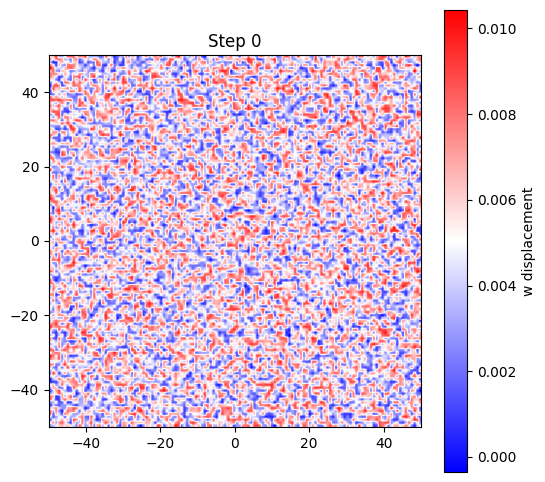

C:\Users\Hp\AppData\Local\Temp\ipykernel_14940\4167743249.py:76: RuntimeWarning: overflow encountered in multiply
  np.gradient(w_x * (u1_x + u2_y + w_x * w_y), axis=1) +
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:1238: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:1259: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:1266: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
C:\Users\Hp\AppData\Local\Temp\ipykernel_14940\4167743249.py:77: RuntimeWarning: overflow encountered in multiply
  np.gradient(w_y * (u1_x + u2_y + w_x * w_y), axis=0)
C:\Users\Hp\AppData\Local\Temp\ipykernel_14940\4167743249.py:82: RuntimeWarning: overflow enco

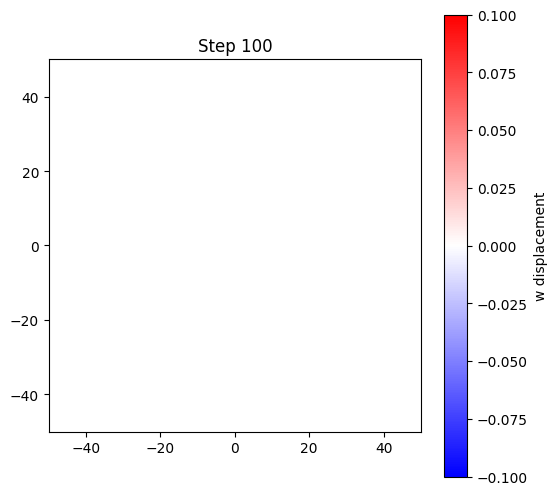

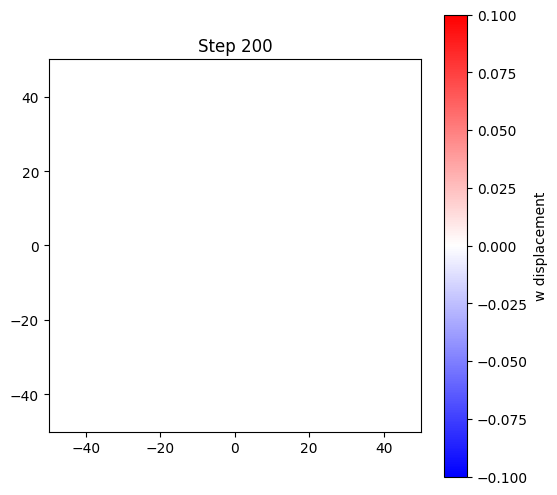

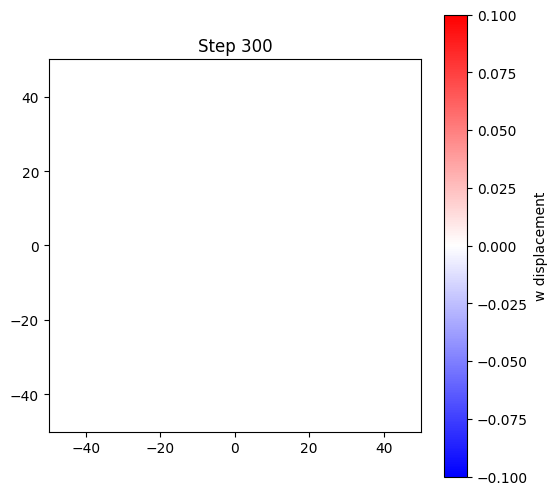

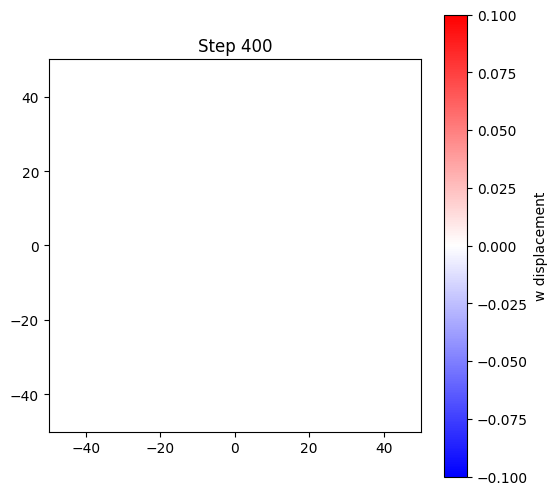

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2

# Set grid size and parameters
N = 128  # Grid size
L = 100  # Physical size
dx = L / N
x = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, x)

# Constants
E_b = 1.0
E_c = 1.5
h_b = 0.2
h_c = 0.1
gamma = 0.1
dt = 0.001  # Smaller Time step to avoid overflow
n_steps = 500  # Number of steps

# Initial conditions: small random perturbations for w and u_alpha
w = np.random.rand(N, N) * 0.01  # Smaller perturbation to avoid overflow
u_alpha = [np.random.rand(N, N) * 0.01 for _ in range(2)]  # u1 and u2

# Fourier space setup
kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(N, d=dx) * 2 * np.pi
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2
k4 = k2**2

# Ensure small k values don't cause overflow by setting a minimum threshold
k2[k2 == 0] = 1e-10
k4[k4 == 0] = 1e-10

# Elastic force matrix in Fourier space
def elastic_force_matrix(kx, ky, E_b, E_c, h_b, h_c):
    k = np.sqrt(kx**2 + ky**2)
    k[k == 0] = 1e-10  # Avoid division by zero
    M = np.zeros((3, 3, N, N))
    M[0, 0] = (2 * k2 - ky**2) / k
    M[0, 1] = kx * ky / k
    M[1, 0] = kx * ky / k
    M[1, 1] = (2 * k2 - kx**2) / k
    M[2, 2] = 2 * k
    f_el = 3 * (E_b / E_c) * (h_b / h_c)**(1/3) * M
    return f_el

# Elastic force in Fourier space
f_el = elastic_force_matrix(kx, ky, E_b, E_c, h_b, h_c)

# Spatial derivatives of w and u_alpha
def compute_derivatives(w, u_alpha):
    w_x = np.gradient(w, axis=1, edge_order=2)  # d/dx
    w_y = np.gradient(w, axis=0, edge_order=2)  # d/dy
    u1_x = np.gradient(u_alpha[0], axis=1, edge_order=2)  # du1/dx
    u1_y = np.gradient(u_alpha[0], axis=0, edge_order=2)  # du1/dy
    u2_x = np.gradient(u_alpha[1], axis=1, edge_order=2)  # du2/dx
    u2_y = np.gradient(u_alpha[1], axis=0, edge_order=2)  # du2/dy
    return w_x, w_y, u1_x, u1_y, u2_x, u2_y

# Time-stepping loop
for step in range(n_steps):
    # Compute derivatives in real space
    w_x, w_y, u1_x, u1_y, u2_x, u2_y = compute_derivatives(w, u_alpha)

    # Fourier transforms of w and u_alpha
    w_hat = fft2(w)
    u_alpha_hat = [fft2(u) for u in u_alpha]

    # Compute nonlinear terms in real space
    nonlinear_term_w = (
        9 * (h_b / h_c)**(1/3) * (E_b / E_c) * (
            np.gradient(w_x * (u1_x + u2_y + w_x * w_y), axis=1) + 
            np.gradient(w_y * (u1_x + u2_y + w_x * w_y), axis=0)
        )
    )
    nonlinear_term_u = [
        9 * (h_b / h_c)**(1/3) * (E_b / E_c) * (
            np.gradient(u_x * (u1_x + u2_y + w_x * w_y), axis=1) + 
            np.gradient(u_y * (u1_x + u2_y + w_x * w_y), axis=0)
        )
        for u_x, u_y in zip([u1_x, u2_x], [u1_y, u2_y])
    ]

    # Update w in Fourier space with semi-implicit scheme
    w_hat_new = (w_hat - dt * (k4 * w_hat + gamma * k2 * w_hat) + fft2(nonlinear_term_w)) / (1 + dt * k4)

    # Update u_alpha in Fourier space
    for i in range(2):
        u_alpha_hat[i] = (u_alpha_hat[i] - dt * f_el[i, i] * w_hat_new + fft2(nonlinear_term_u[i])) / (1 + dt * k2)

    # Inverse FFT to get real space fields
    w = np.real(ifft2(w_hat_new))
    u_alpha = [np.real(ifft2(u)) for u in u_alpha_hat]

    # Visualization every 100 steps
    if step % 100 == 0:
        plt.figure(figsize=(6, 6))
        plt.imshow(w, extent=(-L/2, L/2, -L/2, L/2), cmap='bwr')
        plt.colorbar(label='w displacement')
        plt.title(f'Step {step}')
        plt.show()
